<a href="https://colab.research.google.com/github/fdeiab/loan-default-prediction/blob/main/Loan_Default_Predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

Loan approval is a critical decision for any lending institution. One of two scenarios may happen, the bank loses out on potential income by rejecting a loan to an individual or a company. Or, they lend a loan to a party exhibiting risky behaviour where heavy losses. This uncertainty is why it is a good idea that banks utilize good loan default prediction models as they stand much to gain. 

**The major goal of this notebook is to assess if a loan should be approved and predict whether a loan will default.**

# The Data

The [dataset](https://www.kaggle.com/datasets/larsen0966/sba-loans-case-data-set) used in this project, "SBA Case", is a subset of the "National SBA" data, which contains historical data from 1987 through 2014. The subset dataset focuses mostly on the state of California through the years of 1989 to 2012, although there are other American states included. The dataset used contains **2,102** records under **35** attributes:

| **Variable Name**   | **Description of Variable**                            |
|:-------------------:|:------------------------------------------------------:|
|  LoanNr\_ChkDgt     |  Identifier – Primary key                              |
|  Name               |  Borrower name                                         |
|  City               |  Borrower city                                         |
|  State              |  Borrower state                                        |
|  Zip                |  Borrower zip code                                     |
|  Bank               |  Bank name                                             |
|  BankState          |  Bank state                                            |
|  NAICS              |  North American industry classification system code    |
|  ApprovalDate       |  Date SBA commitment issued                            |
|  ApprovalFY         |  Fiscal year of commitment                             |
|  Term               |  Loan term in months                                   |
|  NoEmp              |  Number of business employees                          |
|  NewExist           |  1 = Existing business, 2 = New business               |
|  CreateJob          |  Number of jobs created                                |
|  RetainedJob        |  Number of jobs retained                               |
|  FranchiseCode      |  Franchise code, \(00000 or 00001\) = No franchise     |
|  UrbanRural         |  1 = Urban, 2 = rural, 0 = undefined                   |
|  RevLineCr          |  Revolving line of credit: Y = Yes, N = No             |
|  LowDoc             |  LowDoc Loan Program: Y = Yes, N = No                  |
|  ChgOffDate         |  The date when a loan is declared to be in default     |
|  DisbursementDate   |  Disbursement date                                     |
|  DisbursementGross  |  Amount disbursed                                      |
|  BalanceGross       |  Gross amount outstanding                              |
|  MIS\_Status        |  Loan status charged off = CHGOFF, Paid in full = PIF  |
|  ChgOffPrinGr       |  Charged\-off amount                                   |
|  GrAppv             |  Gross amount of loan approved by bank                 |
|  SBA\_Appv          |  SBA's guaranteed amount of approved loan              |
|  New         |  =1 if NewExist=2 \(New Business\), =0 if NewExist=1 \(Existing Business\)                                                                  |
|  Portion     |  Proportion of gross amount guaranteed by SBA                                                                                               |
|  RealEstate  |  =1 if loan is backed by real estate, =0 otherwise                                                                                          |
|  Recession   |  =1 if loan is active during Great Recession, =0 otherwise                                                                                  |
|  Selected    |  =1 if the data are selected as training data to build model for assignment, =0 if the data are selected as testing data to validate model  |
|  Default     |  =1 if MIS\_Status=CHGOFF, =0 if MIS\_Status=PIF                                                                                            |
|  daysterm    |  Extra variable generated when creating “Recession” in Section 4\.1\.6                                                                      |
|  xx          |  Extra variable generated when creating “Recession” in Section 4\.1\.6                                                                      |


Logistic Regression will be used for this project to predict odds ratios and probabilities of a loan defaulting or not.

Target value for this project: **MIS\_Status** / **Default** (dummy one-hot encoding of MIS_Status

In [1]:
#@title #Importing Libraries & Loading The Dataset 
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

!pip install pandera
import pandera as pa
from pandera import Column, DataFrameSchema, Int, Check
import warnings # warning filter

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

sns.set_style('whitegrid')
# handle warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('/content/drive/MyDrive/SBAcase.11.13.17.csv')



# Step 1. Exploratory Data Analysis

First, we'll examine the number of null values present, the column data types, and the summary statistics to tell us more about the dataset.


In [2]:
df.info()
# to show all 35 columns 
pd.set_option('display.max_columns', None)
df.describe()
df.isnull().sum()* 100 / len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102 entries, 0 to 2101
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Selected           2102 non-null   int64  
 1   LoanNr_ChkDgt      2102 non-null   int64  
 2   Name               2102 non-null   object 
 3   City               2102 non-null   object 
 4   State              2102 non-null   object 
 5   Zip                2102 non-null   int64  
 6   Bank               2099 non-null   object 
 7   BankState          2099 non-null   object 
 8   NAICS              2102 non-null   int64  
 9   ApprovalDate       2102 non-null   int64  
 10  ApprovalFY         2102 non-null   int64  
 11  Term               2102 non-null   int64  
 12  NoEmp              2102 non-null   int64  
 13  NewExist           2101 non-null   float64
 14  CreateJob          2102 non-null   int64  
 15  RetainedJob        2102 non-null   int64  
 16  FranchiseCode      2102 

Selected              0.000000
LoanNr_ChkDgt         0.000000
Name                  0.000000
City                  0.000000
State                 0.000000
Zip                   0.000000
Bank                  0.142721
BankState             0.142721
NAICS                 0.000000
ApprovalDate          0.000000
ApprovalFY            0.000000
Term                  0.000000
NoEmp                 0.000000
NewExist              0.047574
CreateJob             0.000000
RetainedJob           0.000000
FranchiseCode         0.000000
UrbanRural            0.000000
RevLineCr             0.095147
LowDoc                0.142721
ChgOffDate           66.841104
DisbursementDate      0.142721
DisbursementGross     0.000000
BalanceGross          0.000000
MIS_Status            0.000000
ChgOffPrinGr          0.000000
GrAppv                0.000000
SBA_Appv              0.000000
New                   0.000000
RealEstate            0.000000
Portion               0.000000
Recession             0.000000
daysterm

We can see that the columns 'Bank', 'BankState', 'NewExist', 'RevLineCr','LowDoc', 'ChgOffDate', 'DisbursementDate', and 'xx' have null values. Let's take a look to determine data cleaning strategies

In [3]:
df[df['Bank'].isna()]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1004,0,3341713002,SPOTLIGHT VIDEO,WESTMINSTER,CA,92683,NaN,NaN,532230,10554,1989,120,4,1.0,0,0,0,0,N,N,NaN,10623.0,80000,0,P I F,0,80000,70240,0,0,0.878,0,3600,14223.0,0
1062,1,3685063001,LEADER VIDEO NETWORK 351,MIRA LOMA,CA,91752,NaN,NaN,532230,10947,1990,120,1,1.0,0,0,1,0,N,N,NaN,10988.0,60000,0,P I F,0,60000,54000,0,0,0.900,0,3600,14588.0,0
1204,0,4429443003,COURTESY AUTO RENTAL OF CHULA,SAN DIEGO,CA,91910,NaN,NaN,532111,11427,1991,60,1,1.0,0,0,1,0,N,N,NaN,11534.0,288000,0,P I F,0,288000,244800,0,0,0.850,0,1800,13334.0,0


In [4]:
df[df['BankState'].isna()]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1004,0,3341713002,SPOTLIGHT VIDEO,WESTMINSTER,CA,92683,NaN,NaN,532230,10554,1989,120,4,1.0,0,0,0,0,N,N,NaN,10623.0,80000,0,P I F,0,80000,70240,0,0,0.878,0,3600,14223.0,0
1062,1,3685063001,LEADER VIDEO NETWORK 351,MIRA LOMA,CA,91752,NaN,NaN,532230,10947,1990,120,1,1.0,0,0,1,0,N,N,NaN,10988.0,60000,0,P I F,0,60000,54000,0,0,0.900,0,3600,14588.0,0
1204,0,4429443003,COURTESY AUTO RENTAL OF CHULA,SAN DIEGO,CA,91910,NaN,NaN,532111,11427,1991,60,1,1.0,0,0,1,0,N,N,NaN,11534.0,288000,0,P I F,0,288000,244800,0,0,0.850,0,1800,13334.0,0


In [5]:
df[df['RevLineCr'].isna()]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1858,0,8132923002,"MOVIE MOVERS,ET AL",VAN NUYS,CA,91405,"CITIBANK, N.A.",CA,532120,12843,1995,120,25,1.0,0,0,1,0,NaN,N,NaN,12903.0,700000,0,P I F,0,700000,595000,0,0,0.85,0,3600,16503.0,0
1861,0,8168453005,"HALE VIDEO ENTERPRISES, INC.",ANDERSON,CA,96007,REDDING BANK OF COMMERCE,CA,532230,12855,1995,300,9,1.0,0,0,1,0,NaN,N,NaN,13087.0,495000,0,P I F,0,495000,371250,0,1,0.75,0,9000,22087.0,0


In [6]:
df[df['LowDoc'].isna()]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1017,1,3406645010,STREET RODS & EXOTIC CAR RENTA,RANCHO SANTA MARGARITA,CA,92688,"SUPERIOR FINANCIAL GROUP, LLC",CA,532111,18021,2009,99,7,2.0,5,7,0,1,N,NaN,18890.0,18048.0,7500,0,CHGOFF,6706,7500,6750,1,0,0.9,0,2970,21018.0,1
1114,0,4014285004,Kenneth L. Ching,Fair Oaks,CA,95628,SAFE CU,CA,531210,18358,2010,84,4,1.0,2,4,0,1,Y,NaN,NaN,18358.0,35000,0,P I F,0,35000,31500,0,0,0.9,0,2520,20878.0,0
1124,1,4066645007,LOCATE GREEN HOMES LLC,TURLOCK,CA,95380,"SUPERIOR FINANCIAL GROUP, LLC",CA,531390,18388,2010,85,2,2.0,2,2,0,1,N,NaN,19600.0,18388.0,5000,0,P I F,4146,5000,4500,1,0,0.9,0,2550,20938.0,0


In [7]:
df[df['DisbursementDate'].isna()]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1255,0,4910065006,Elite Cooling,HUNTINGTON BEACH,CA,92647,JPMORGAN CHASE BANK NATL ASSOC,IL,532210,18911,2012,84,1,1.0,0,0,0,1,Y,N,NaN,NaN,14915,0,P I F,0,10000,5000,0,0,0.5,0,2520,NaN,0
1691,1,7253454001,UNITY ESCROW INC,ARTESIA,CA,90701,BBCN BANK,CA,531390,16140,2004,12,13,1.0,2,15,1,1,Y,N,NaN,NaN,100000,0,P I F,0,100000,50000,0,0,0.5,0,360,NaN,0
2101,0,9958873001,EFM ASSOCIATES,LOS ANGELES,CA,90068,WELLS FARGO BANK NATL ASSOC,SD,531110,13557,1997,60,4,1.0,0,0,1,0,T,N,NaN,NaN,35000,0,P I F,0,35000,17500,0,0,0.5,0,1800,NaN,0


In [8]:
df[df['xx'].isna()]

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
1255,0,4910065006,Elite Cooling,HUNTINGTON BEACH,CA,92647,JPMORGAN CHASE BANK NATL ASSOC,IL,532210,18911,2012,84,1,1.0,0,0,0,1,Y,N,NaN,NaN,14915,0,P I F,0,10000,5000,0,0,0.5,0,2520,NaN,0
1691,1,7253454001,UNITY ESCROW INC,ARTESIA,CA,90701,BBCN BANK,CA,531390,16140,2004,12,13,1.0,2,15,1,1,Y,N,NaN,NaN,100000,0,P I F,0,100000,50000,0,0,0.5,0,360,NaN,0
2101,0,9958873001,EFM ASSOCIATES,LOS ANGELES,CA,90068,WELLS FARGO BANK NATL ASSOC,SD,531110,13557,1997,60,4,1.0,0,0,1,0,T,N,NaN,NaN,35000,0,P I F,0,35000,17500,0,0,0.5,0,1800,NaN,0


## Handle Missing Data
The ChgOffDate Column (date a loan is entered into default) is comprised of approximately 67% of missing values, which may appear concerning at first, but if we take a look at the percentage of loans that are paid in full below, it agrees with the number of null values. This is a case of NMAR (not missing at random). Therefore, the missing values will not be filled in or removed to display the true nature of defaulted and paid-off loans. However, we will take this decision into consideration when making conclusions that may be sensitive to the null values.

For the remaining seven columns, we will drop the rows as appropriate data could not be located to fill in, they are small in number, and they cannot be filled using techniques such as mode or mean as that would result in inaccurate data that could possibly skew results. 




In [9]:
df['Default'].value_counts()[0]* 100 / len(df)
df.dropna(subset=['Bank', 'BankState', 'NewExist','RevLineCr','LowDoc', 'DisbursementDate', 'xx'], inplace=True)
df.isnull().sum()* 100 / len(df)

Selected              0.000000
LoanNr_ChkDgt         0.000000
Name                  0.000000
City                  0.000000
State                 0.000000
Zip                   0.000000
Bank                  0.000000
BankState             0.000000
NAICS                 0.000000
ApprovalDate          0.000000
ApprovalFY            0.000000
Term                  0.000000
NoEmp                 0.000000
NewExist              0.000000
CreateJob             0.000000
RetainedJob           0.000000
FranchiseCode         0.000000
UrbanRural            0.000000
RevLineCr             0.000000
LowDoc                0.000000
ChgOffDate           66.746411
DisbursementDate      0.000000
DisbursementGross     0.000000
BalanceGross          0.000000
MIS_Status            0.000000
ChgOffPrinGr          0.000000
GrAppv                0.000000
SBA_Appv              0.000000
New                   0.000000
RealEstate            0.000000
Portion               0.000000
Recession             0.000000
daysterm

Our data now only contains purposeful null values.

## Data Validation

Next, we want to make sure that our data has no quality issues and can be used with confidence. For this step, I will be using the [Pandera Library](https://pandera.readthedocs.io/en/stable/index.html) which is a flexible data validation tool.

In [10]:
# create our schema to test our data against it's expected results
schema = DataFrameSchema(
    {
        "LoanNr_ChkDgt": Column(int),
        "Selected": Column(int, Check.isin([0, 1])),
        "Name": Column(str),
        "City": Column(str),
        "State": Column(str),
        "Zip": Column(int),
        "Bank": Column(str),
        "BankState": Column(str),
        "NAICS": Column(int),
        "ApprovalDate": Column(int),
        "ApprovalFY": Column(int),
        "Term": Column(int),
        "NoEmp": Column(int),
        "NewExist": Column(float, Check.isin([1, 2])),
        "CreateJob": Column(int),
        "RetainedJob": Column(int),
        "FranchiseCode": Column(int),
        "UrbanRural": Column(int, Check.isin([0, 1, 2])),
        "RevLineCr": Column(str, Check.isin(['Y', 'N'])),
        "LowDoc": Column(str, Check.isin(['Y', 'N'])),
        "ChgOffDate": Column(float, nullable=True),
        "DisbursementDate": Column(float),
        "DisbursementGross": Column(int),
        "BalanceGross": Column(int),
        "MIS_Status": Column(str, Check.isin(['P I F', 'CHGOFF'])),
        "ChgOffPrinGr": Column(int),
        "GrAppv": Column(int),
        "SBA_Appv": Column(int),
        "New": Column(int),
        "RealEstate": Column(int),
        "Portion": Column(float),
        "Recession": Column(int),
        "daysterm": Column(int),
        "xx": Column(float),
        "Default": Column(int, Check.isin([0, 1])),
    },
    unique=["LoanNr_ChkDgt"],
)
try:
    validated_df = schema.validate(df, lazy=True)
except pa.errors.SchemaErrors as err:
    print("Schema errors and failure cases:")
    print(err)
  

Schema errors and failure cases:
Schema None: A total of 3 schema errors were found.

Error Counts
------------
- SchemaErrorReason.SCHEMA_COMPONENT_CHECK: 3

Schema Error Summary
--------------------
                                          failure_cases  n_failure_cases
schema_context column    check                                          
Column         LowDoc    isin(['Y', 'N'])     [S, A, 0]                3
               NewExist  isin([1, 2])             [0.0]                1
               RevLineCr isin(['Y', 'N'])        [0, T]                2

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.failure_cases  # dataframe of schema errors
    err.data  # invalid dataframe
```



As produced by the validate method, the following columns contain data entry errors: NewExist, LowDoc, and RevLineCr

In [11]:
#@title Fix Data Schema Errors

# assuming human entry error, replace '0' to '1'
df['NewExist'] = df['NewExist'].replace(to_replace=0, value=1)
print(f"NewExist Values {df['NewExist'].unique()}")
# replace incorrect '0' to 'N' and 'T' to 'Y'
df['RevLineCr'] = df['RevLineCr'].replace(to_replace='0', value='N')
df['RevLineCr'] = df['RevLineCr'].replace(to_replace='T', value='Y')
print(f"RevLineCr Values {df['RevLineCr'].unique()}")

# replace '0' to 'N'
# other values will be replaced with the mode value of that column
df['LowDoc'] = df['LowDoc'].replace(to_replace='0', value='N')
df['LowDoc'] = df['LowDoc'].replace(to_replace='S', value=df['LowDoc'].mode()[0])
df['LowDoc'] = df['LowDoc'].replace(to_replace='A', value=df['LowDoc'].mode()[0])
print(f"LowDoc Values {df['LowDoc'].unique()}")

try:
    validated_df = schema.validate(df, lazy=True)
except pa.errors.SchemaErrors as err:
    print("Schema errors and failure cases:")
    print(err)


NewExist Values [1. 2.]
RevLineCr Values ['Y' 'N']
LowDoc Values ['N' 'Y']


## Data Transformation
Lastly, we will extract from the NAICS column the first two digits that tell us the business industry type. We will also convert the categorical columns into indicator variables.


In [12]:
# NAICS transformation
df.NAICS = df.NAICS.apply(lambda x: int(str(x)[:2]))

# categorical transformation
RevLineCr = pd.get_dummies(df['RevLineCr'], drop_first=True)
LowDoc = pd.get_dummies(df['LowDoc'], drop_first=True)
df.drop(['RevLineCr', 'LowDoc'], axis=1, inplace=True)
df['RevLineCr'] = RevLineCr['Y']
df['LowDoc'] = LowDoc['Y']

print(f"NAICS Values {df['NAICS'].unique()}")
print(f"RevLineCr Values {df['RevLineCr'].unique()}")
print(f"LowDoc Values {df['LowDoc'].unique()}")

NAICS Values [53]
RevLineCr Values [1 0]
LowDoc Values [0 1]


Before we can move onto visualizing and modelling our data, we need to remove non-impactful features to potentially improve model accuracy and reduce computational time. 

---
### Preperation

From the dataset, there are columns which provide informative data that won't help our model. 

**Personal and Bank Information**
* LoanNr_ChkDgt: Loan Identifier  
* Name: Borrower Name
* City: Borrower City
* State: Borrower State
* Zip: Borrower Zip Code
* Bank: Bank Name
* BankState: Bank State
* FranchiseCode: Franchise Code

**Date and Time Information**
* ApprovalDate: Date SBA commitment issued
* ApprovalFY: Fiscal year of commitment
* ChgOffDate: Date when a loan is declared to be in default
* DisbursementDate: Disbursement date

**Loan Information**
* DisbursementGross: Amount disbursed
* BalanceGross: Gross amount outstanding
* ChgOffPrinGr: Charged-off amount

The above 14 columns will be dropped from our dataset as they provide additional
information that can't be used for our model. 

We can also drop 'MIS_Status' as it is encoded in 'Default', 'NewExist' as it is encoded in 'New', 'xx' and 'daysterm' as they are not needed. 

In [13]:
df.head()
data = df.drop(['LoanNr_ChkDgt', 'Name','City', 'State', 'Zip','Bank','BankState',
                'FranchiseCode', 'ApprovalDate','ApprovalFY','ChgOffDate','DisbursementDate','BalanceGross',
                 'DisbursementGross','ChgOffPrinGr', 'MIS_Status', 'xx', 'daysterm', 'NewExist'], axis=1)

# move target variable to the end
def_col = data.pop("Default")
data.insert(data.shape[1], def_col.name, def_col)


Now that our data is validated, cleaned, and transformed we can move onto creating visualizations.

### Data Visualizations

Within this step, we can get an overview of the insights from the dataset; we can discover trends, patterns, and relationships that are not readily apparent.

Data distribution

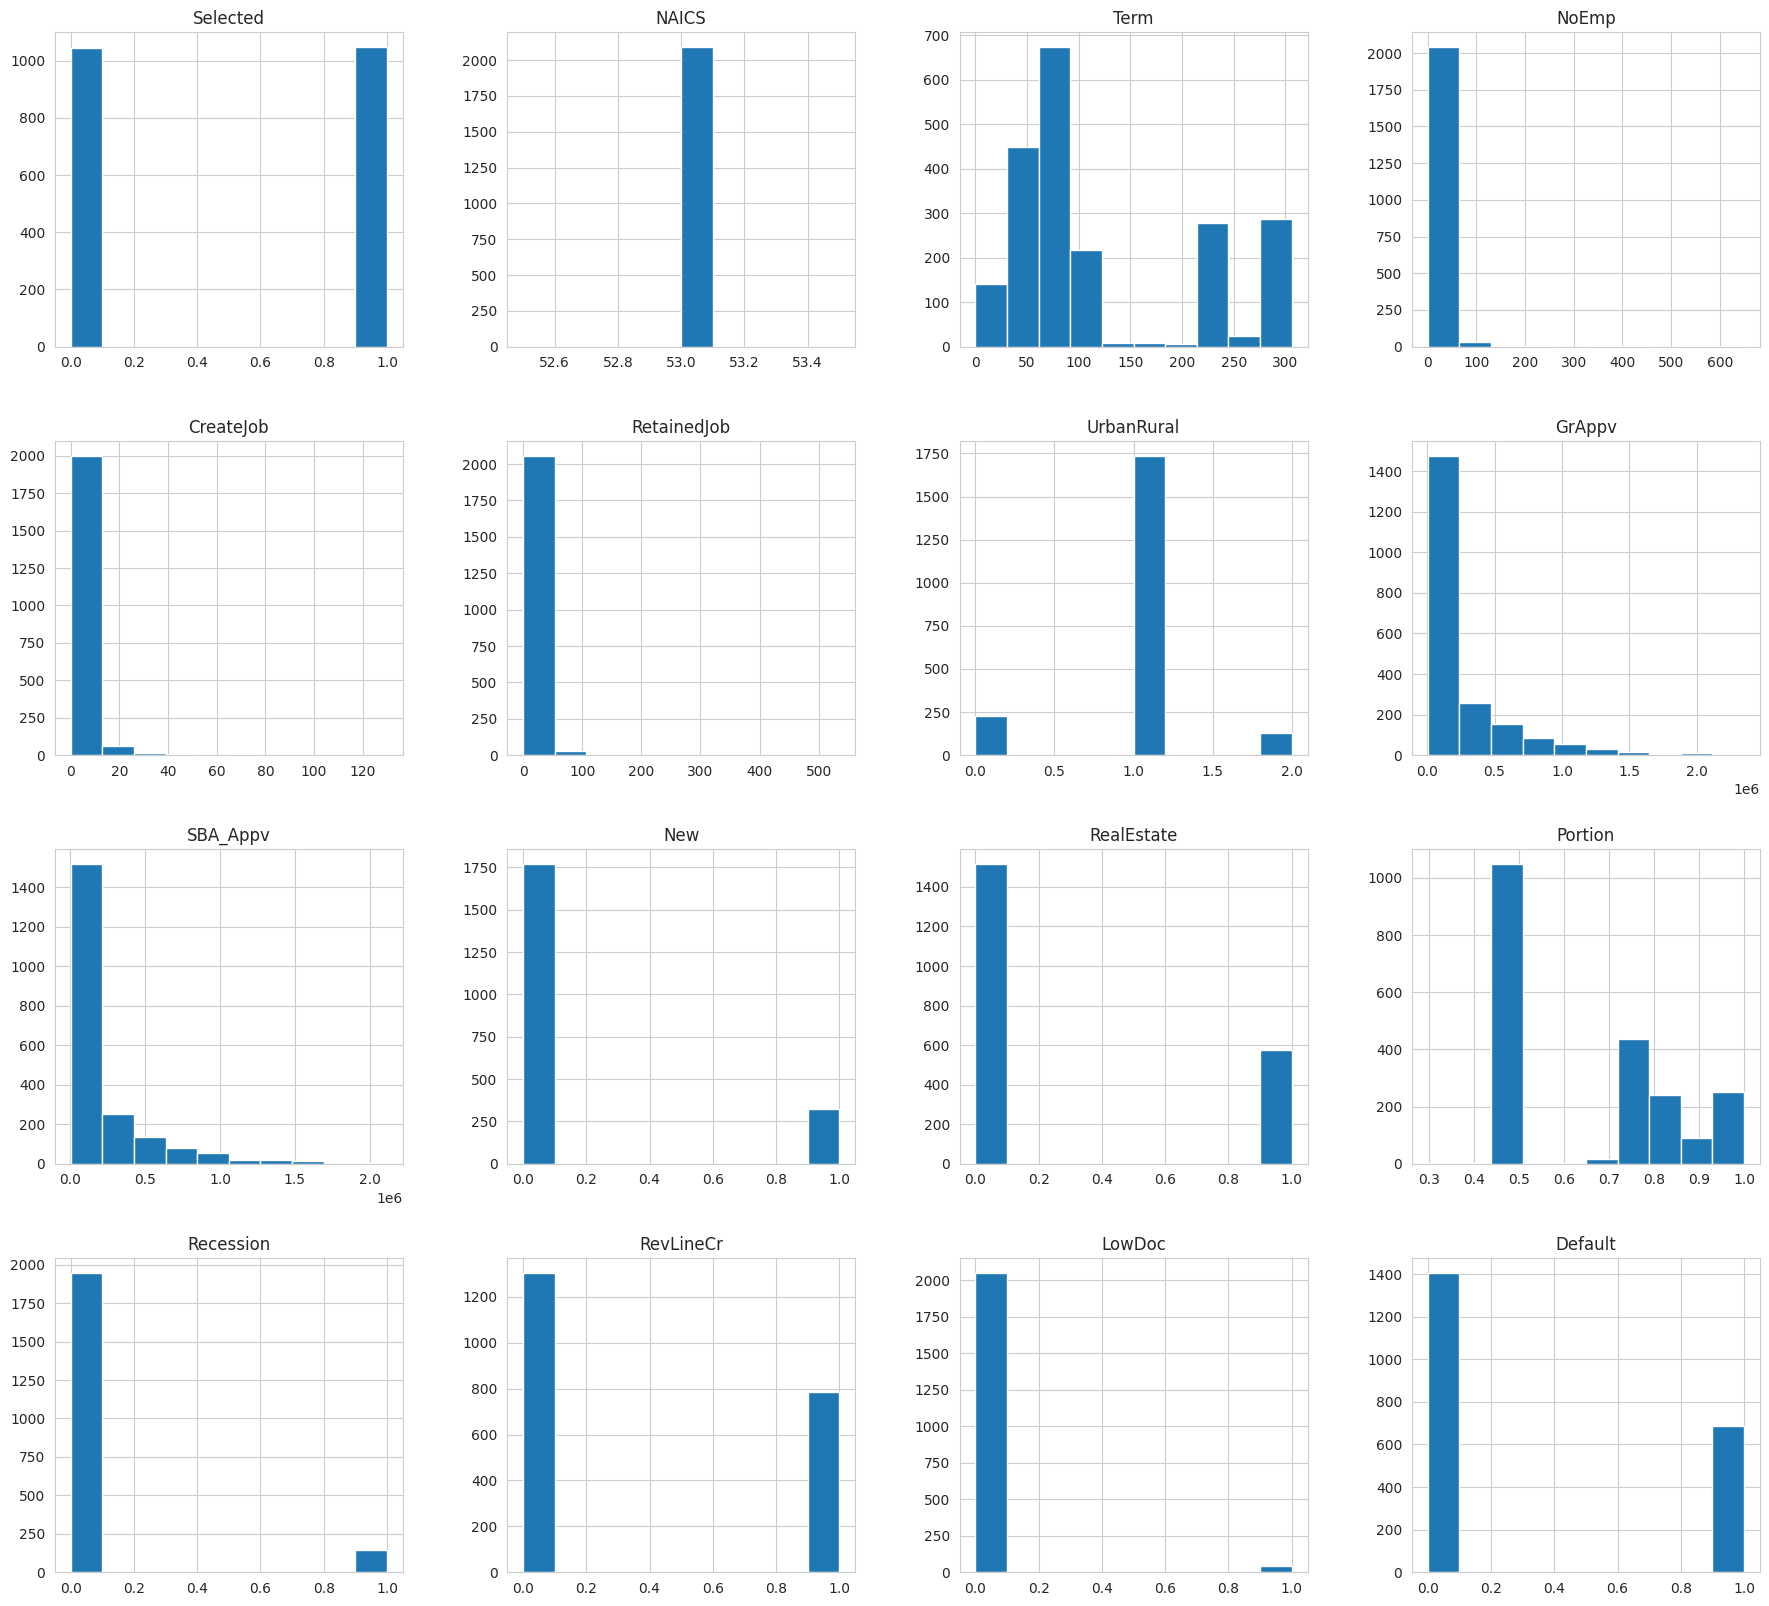

In [14]:
data.hist(figsize = (22, 20))
plt.show()

Companies with Biggest Loans

<Axes: xlabel='GrAppv', ylabel='Name'>

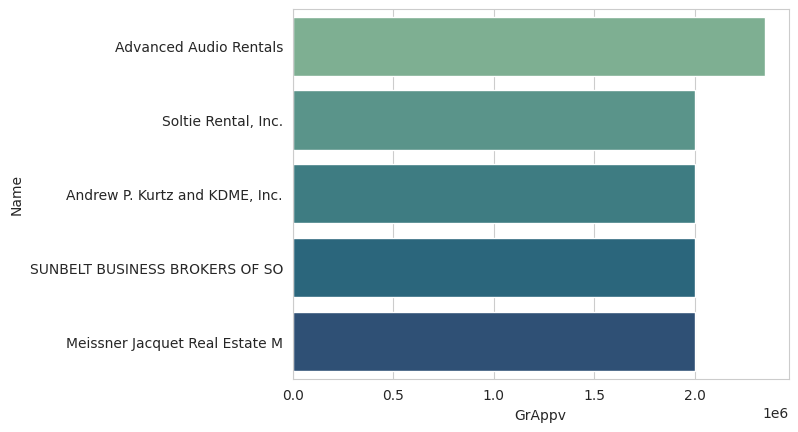

In [15]:
sns.barplot(x='GrAppv' , y='Name', data=df.sort_values('GrAppv',ascending=False).head(5), orient="h", palette="crest")

Companies with longest term

<Axes: xlabel='Term', ylabel='Name'>

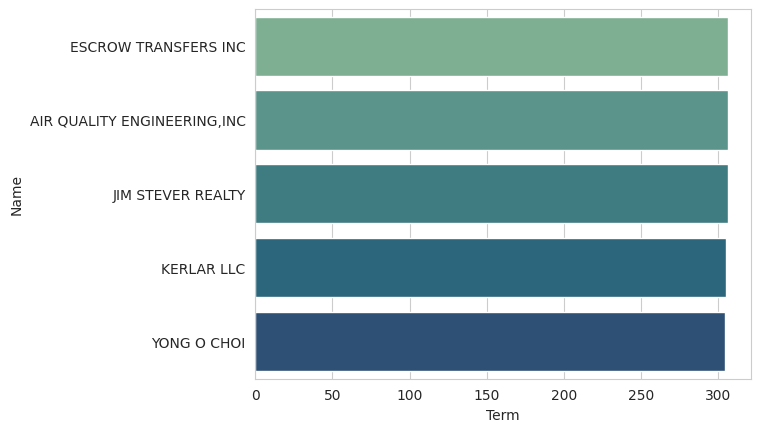

In [16]:
sns.barplot(x='Term' , y='Name', data=df.sort_values('Term',ascending=False).head(5), orient="h", palette="crest")

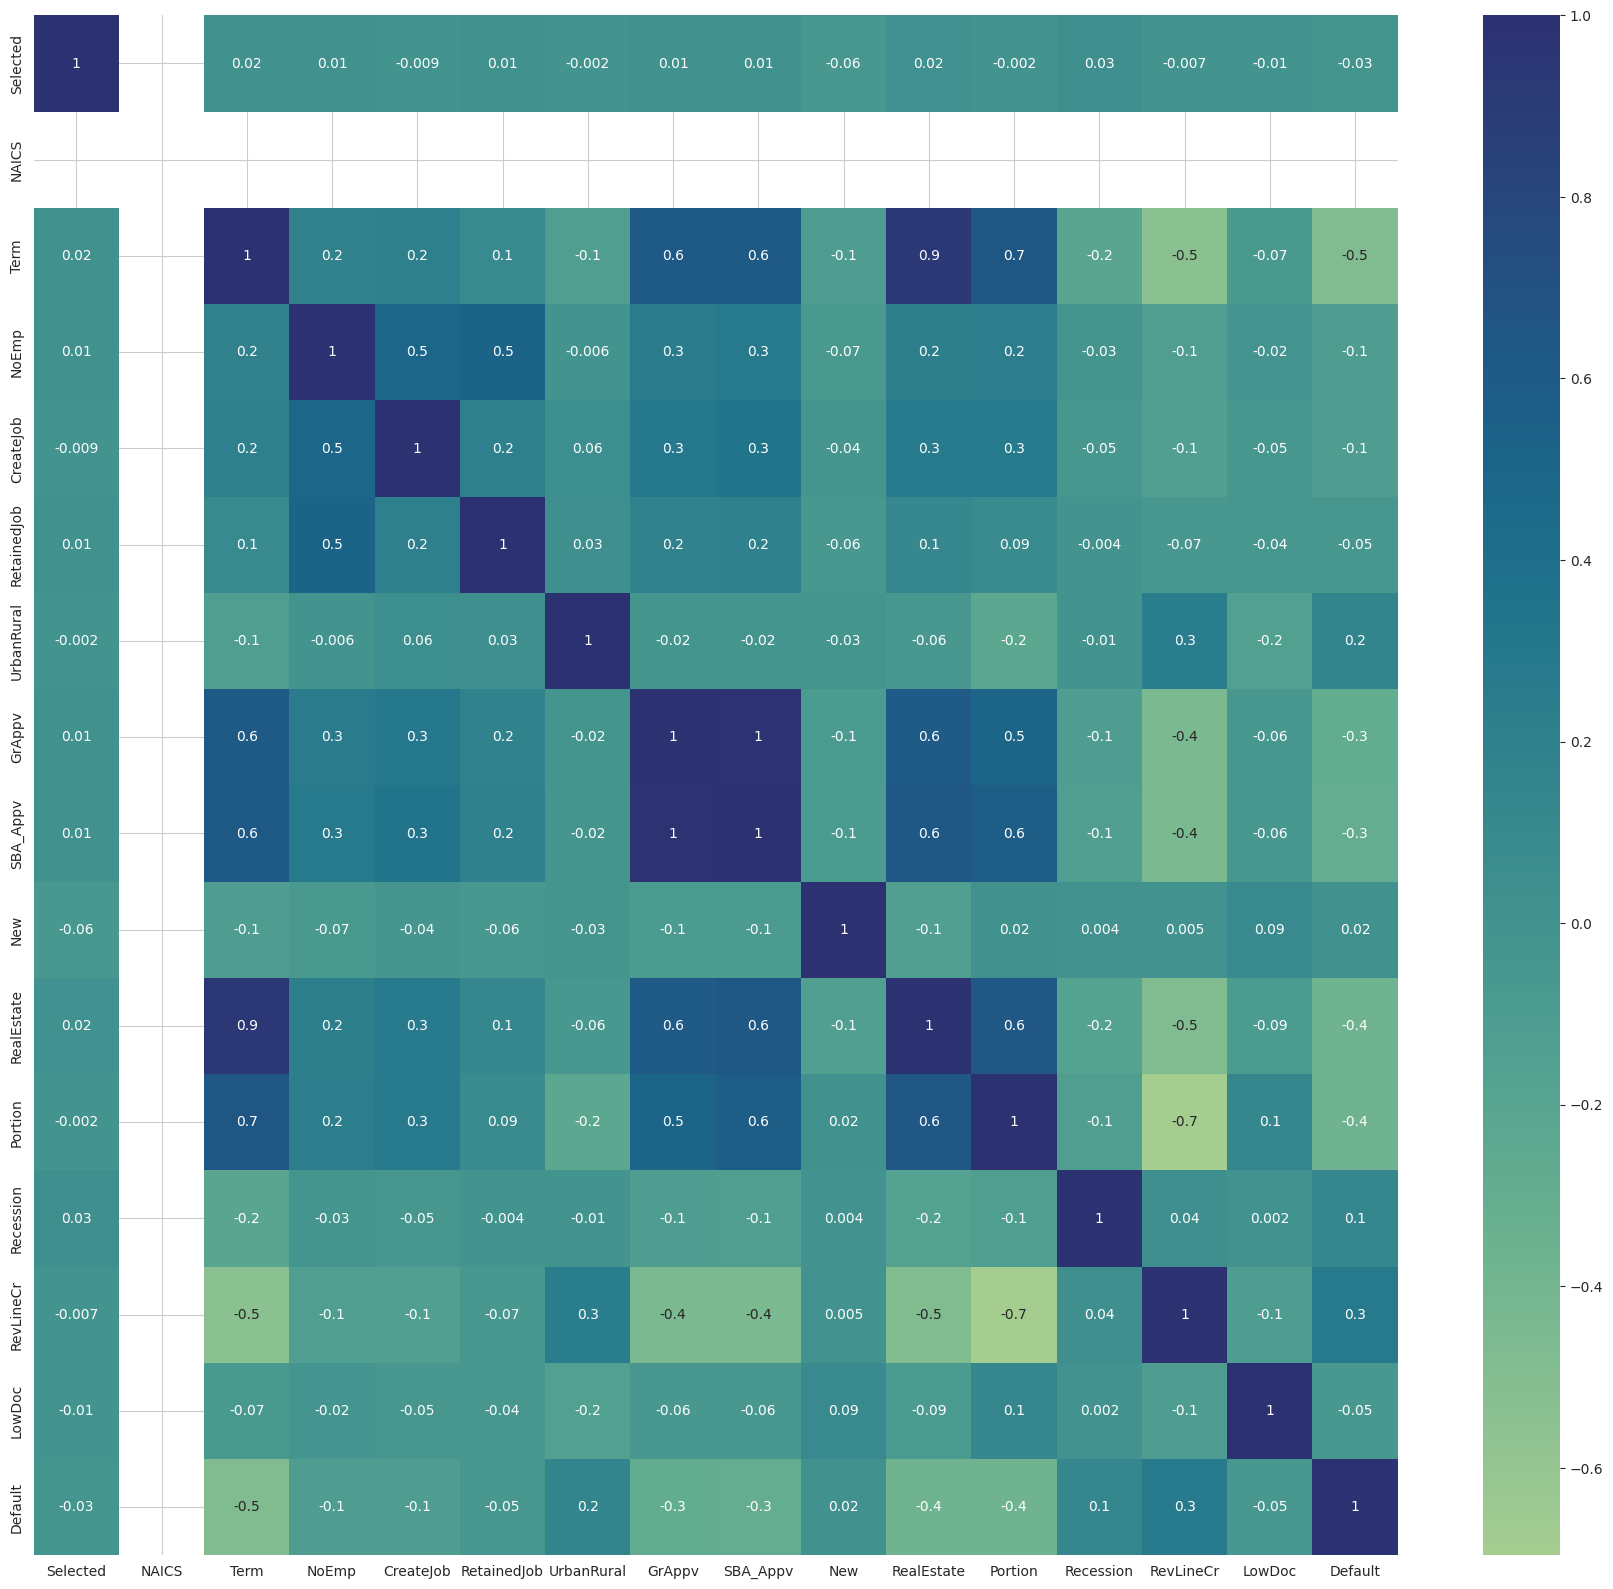

In [17]:
# correlation plot
plt.figure(figsize=(22,20))
corr = data.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="crest", fmt='.1g')


Correlation between Term and Gross Amount

<Axes: xlabel='GrAppv', ylabel='Term'>

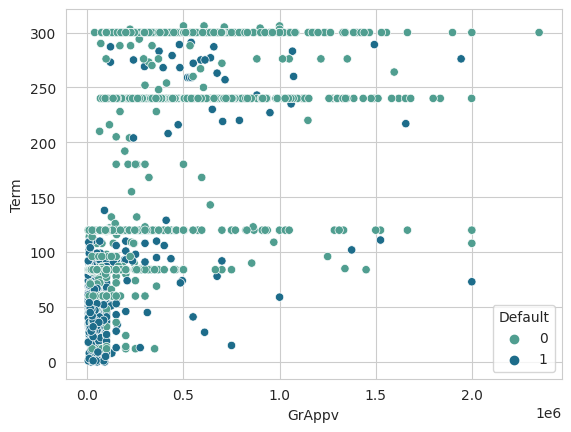

In [18]:
sns.scatterplot(x=df["GrAppv"], y=df["Term"],hue=df["Default"], palette="crest")

Number of loans defaulted vs paid-in-full

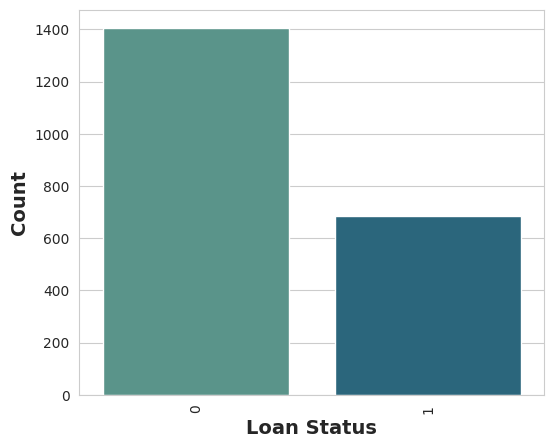

In [19]:
# number of defaults(1) vs paid in full(0)
fig, ax = plt.subplots(1, figsize=(6, 5))
p = sns.countplot(x='Default', data=data, palette='crest')
p.set_xlabel('Loan Status', fontsize= 14, fontweight='bold')
p.set_ylabel('Count', fontsize= 14, fontweight='bold')
plt.xticks(rotation = 90)
plt.show()


# Step 2. Feature Selection 
For this section, we will use Random Forest for feature selection. Random Forest
utilizes its Gini impurity criterion as basis for selection. The feature which helps the model to decrease the impurity is becoming an important feature, which implies that if a feature contributes more to reducing impurity, it becomes more important.

Our **Target Feature (y)** is **Default** (indicator value of MIS_Status)

All other attributes will be our **Training Features (X)**

In [20]:
print(f"Number of training data: {df.loc[df['Selected'] == 1].shape[0]}")
print(f"Number of testing data: {df.loc[df['Selected'] == 0].shape[0]}")


Number of training data: 1047
Number of testing data: 1043


Our values for training and testing data are not imbalanced, so we can move forward.

In [21]:
# columns to scale
cols = ['Term', 'RetainedJob', 'GrAppv', 'SBA_Appv', 'Portion']

# seperate data into training and test data
train = data.loc[data['Selected'] == 1]
test = data.loc[data['Selected'] == 0]

X = data.iloc[:, 1:14]
y = data['Default']

# seperate data into feature and target sets
X_train = train.iloc[:, 1:14]
X_test = test.iloc[:, 1:14]
y_train = train['Default']
y_test = test['Default']

scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])

X_test[cols] = scaler.transform(X_test[cols])

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
feature_imp = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False)

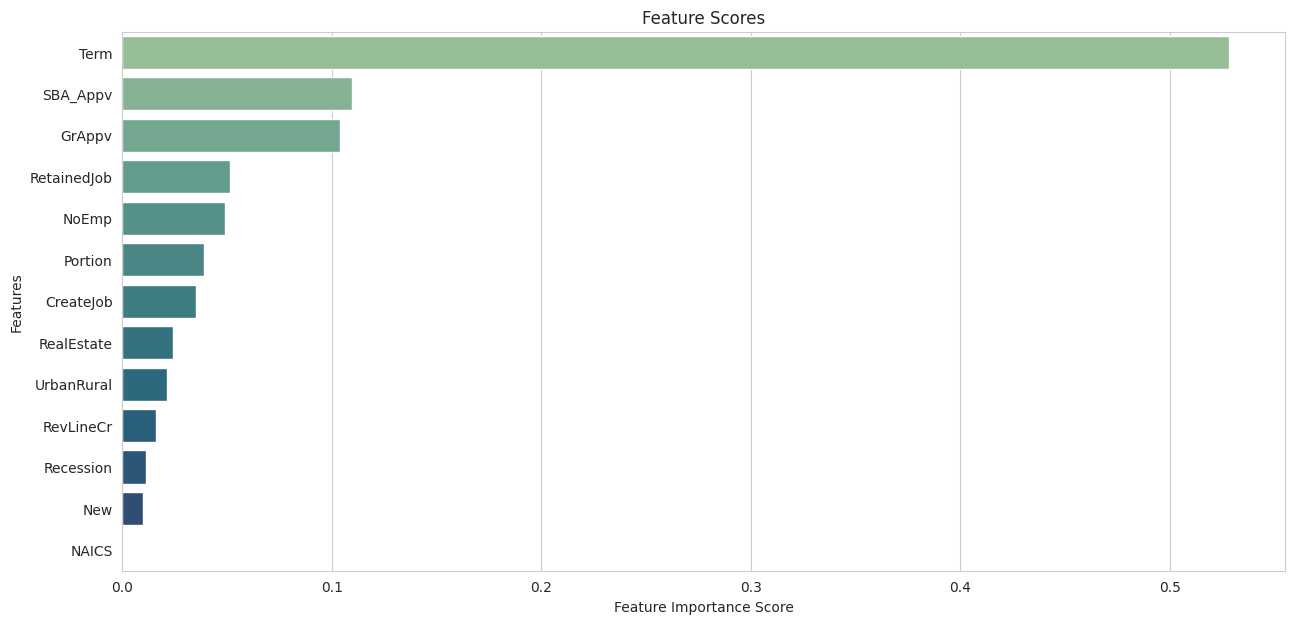

In [22]:
# plot feature importance 
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(x=feature_imp, y=feature_imp.index, palette="crest")
ax.set_title("Feature Scores")
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.show()

According to the diagram above, the Random Forest algorithm determined Term, SBA_Appv, and GrAppv features to be the top three important features for prediction. 

Different algorithms and models may select alternative features as important, which may be explored in the future for this project.

# Step 3. Model Evaluation

Next, we will try multiple classification models and evalute their performance using K-Fold Cross Validation

In [23]:
# this dictionary will hold each model's average cross val score as a %
model_dict = {}
# this function evaluates the given model's accuracy 
def eval_model(model, X_train, X_test, y_train, y_test):
  # train the model
  model.fit(X_train, y_train)
  # perform predicitions on test samples
  y_pred = model.predict(X_test)

  # print results
  print(f"Model: {model} | Accuracy: {accuracy_score(y_test, y_pred)} | AUC: {roc_auc_score(y_test, y_pred)}")

  # calculate average cross validation score and store it 
  cross_val_scr = cross_val_score(model, X_train, y_train, cv=5)
  print(f"Model: {model} | Avg Cross Validation Score: {np.mean(cross_val_scr)}")

  model_dict[model] = round(np.mean(cross_val_scr)*100, 2)

### 1. Logistic Regression

In [24]:
logreg = LogisticRegression()
eval_model(logreg, X_train, X_test, y_train, y_test)


Model: LogisticRegression() | Accuracy: 0.8197507190795782 | AUC: 0.777477071732722
Model: LogisticRegression() | Avg Cross Validation Score: 0.8060469355206197


### 2. Decision Tree Classifier

In [25]:
dtc = DecisionTreeClassifier()
eval_model(dtc, X_train, X_test, y_train, y_test)

Model: DecisionTreeClassifier() | Accuracy: 0.9012464046021093 | AUC: 0.8924234359646249
Model: DecisionTreeClassifier() | Avg Cross Validation Score: 0.903522442469811


### 3. Random Forest Classifier

In [26]:
rfc = RandomForestClassifier()
eval_model(rfc, X_train, X_test, y_train, y_test)

Model: RandomForestClassifier() | Accuracy: 0.9031639501438159 | AUC: 0.8918318047821814
Model: RandomForestClassifier() | Avg Cross Validation Score: 0.893028024606972


### 4. Gradient Boosting Classifier 

In [27]:
gbc = GradientBoostingClassifier()
eval_model(gbc, X_train, X_test, y_train, y_test)

Model: GradientBoostingClassifier() | Accuracy: 0.9415148609779482 | AUC: 0.9304454634785458
Model: GradientBoostingClassifier() | Avg Cross Validation Score: 0.9312143996354523


In [28]:
model_dict

{LogisticRegression(): 80.6,
 DecisionTreeClassifier(): 90.35,
 RandomForestClassifier(): 89.3,
 GradientBoostingClassifier(): 93.12}

Out of the four evaluated models, Gradient Boosting Classifier is the best model for this dataset as its average cross validation score is 93.12% and its AUC is 0.93, which is the highest score closest to 1 out of the four.